# Cohort analysis: Hypertension in children with T1D

In this report, we analyzed the Hypertension in children with T1D cohort to understand the elevated BP subjects. Specifically, we focused on :

* undercoving the determing factors, among potential clinical/demographic/family/immune/genetic variables,  for elevated BP in children with T1D.
* developing a machine learning model to predict elevated BP in children with T1D.


In conclusion, we found that:

- With univariate association analysis (i.e. testing the direct association of each feature with the elevated BP group):
  * the IA2 and BMI are the most significant features associated with the elevated BP group (p<0.05). However, both features are not significant after multiple testing correction (i.e. Bonferroni correction).
  * The BP elevated group have higer IA2 and BMI than the normotensive group.
  * all other features are not significantly associated with the elevated BP group.

- With machine learning models to capture complext interactions among features:
   * **Random Forest** achieved the highest discrimination (ROC AUC ≈ 0.71) among all methods (Figure 1), markedly outperforming all other models. 
   * the dominate features in the random forest model are: BMI, a1C, GRS, IA2, and X96GAD.
   * This demonstrate that even though univariate analysis did not yield significant association results, the machine learning model is able to capture some complex interactions between features to predict the elevated BP group. 
   * However, the prediction performance is still limited by the small sample size, imbalanced data, and lacking of relevant genetic signals in the feture pool.








Updates April 18, 2025:

* We corrected the "elevated BP" calculation according to the diagnosis file.
* we removed 49 subjects who were "not pediatric according to the calculator and study" according to the dianosis file. Note that these subjects are >18 at BP measurement so the calculator is not applicable to them. If we classify them as normal BP group then it would also distort the analysis. Therefore we have to remove these 49 subjects.
* we added two new variables: "age at antibody test" and "age at (the second) BP measurement".
* we re-run analysis accordingly and updated the report.
* We added association analysis of all varibles with the elevated BP group. 

## Variables of interest


### Response Variable

 **elevated_BP**: 
 
* Case group (Y=1):  if the subject has elevated BP, i.e. pediatric patients who have any BP >90th % at both dates that BP was measured.
* Control group (Y=0): otherwise.


* We corrected the "elevated BP" calculation according to the diagnosis file "AccurateDiagnosisInD-HTNProject_DATA_LABELS_2025-01-10_1610.tsv". 
* We remove a single subject 01-309-04. He is an outlier in the age group: he is born on 1999-08-01, not in the pediatric group when taken antibody and BP measurement, and he is 5 years older than any other participants in the final cohort. We remove him to avoid outlier bias effect on the model. 


### Predictors: Genetic Risk Score (GRS)

T1D genetic risk score 2 (GRS2) was calculated using the SNPs from GRS2 paper (Sharp et al. 2019).
- **Features generated:**
  - `IID`, `GRS` (standardized score)

### Predictors: Ancestry & Family History

* Ethnicity (self-reported ethnic origin of 4 grandparents)
* Family history of T1D (yes/no)
* Family history of T1D, T2D or other forms of diabetes in 1st or 2nd degree relatives (yes/no)


- **Features generated:**
  - `cluster_pred_ancestry` (predominant continent where grandparents were born) 
  - `cluster_shannon` (ancestry diversity): high value reflect higher diversity. 
  - `Cluster_family_diabetes` ((yes/no))
  - `cluster_family_12_degree_bin` (Yes/No for 1st/2nd degree relatives)

### Predictors: Clinical Features

* Age at antibody test (days)
* age at BP measurement (days)
* Age at analysis (days)
* BMI (SDS)
* Total daily insulin dose (units/kilogram/day)
* Personal history of other autoimmune disease (yes/no, type of autoimmune disease)
* Markers of diabetes control over the last 3 months: Hemoglobin A1C (%)




- **Features generated:**
  - `cluster_BMI`
  - `cluster_autoimmune_disease`
  - `Cluster_age`
  -  `Cluster_insulin`
  - `Cluster_A1c`
  - `age_at_antibody_test` (days)
  - `age_at_BP_measurement` (days)


### Predictors: Antibody Data

- Glutamic acid decarboxylase 65 (GAD65) autoantibody titers (nmol/L)
- Insulinoma-associated antigen 2 (IA-2) autoantibody titers (nmol/L)
- Zinc transporter 8 (ZnT8) autoantibody titers (nmol/L)


- **Features generated:**
  - `96GAD`
  - `IA2`
  - `ZnT8` 


## Data Processing 


* In total, we obtained 247 subjects, and 20 features of interest. 
* Sample size:  197 Hypertensive vs 50 normotensive subjects.
* note that the reduced number of samples (from 350 subjects) is due to (1) we removed 49 subjects who were "not pediatric according to the calculator and study" in the dianosis file. Note that these subjects are >18 at BP measurement so the calculator is not applicable to them. If we classify them as normal BP group then it would also distort the analysis. Therefore we have to remove these 49 subjects. (2) we also removed subjects that have missing values in the features of interest.
* We processed the highly correlated features (rho>0.95) and normalized the predictors.
* We split the data into training and testing sets (75/25), i.e. we randomly selected 75% of the data for training and 25% for testing.
* We used the training set to train the model and the testing set to evaluate the model performance.


## Summary Statistics


We first conducted summary statistics of the cohort. The summary statistics include the mean, standard deviation, median, minimum, maximum, and interquartile range (IQR) of the features of interest. We also conducted a t-test to compare the means of the features between the elevated BP group and the control group. The results are shown in the table below.

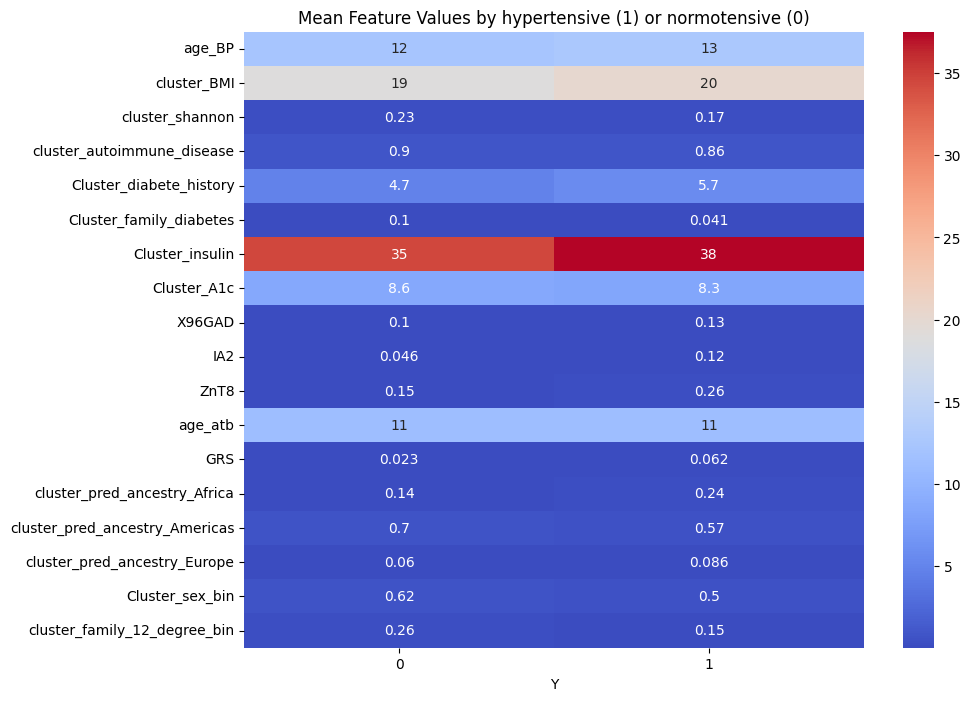

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import sys


#we first load /mnt/c/Per/LaiJiang/Project/ADDAM/HP/results/5_1_split_before.csv
df = pd.read_csv('C:/Per/LaiJiang/Project/ADDAM/HP/results/5_1_split_before.csv')

#remove the unnamed columns
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

#divide the age_atb and age_BP by 365.25 to convert them to years
df['age_atb'] = df['age_atb'] / 365.25
df['age_BP'] = df['age_BP'] / 365.25

#now print summary statsitics of each column in a table
#print(df.describe())

import seaborn as sns

# Group the clinical data by clusters and calculate mean or median for clinical and antibody features
cluster_summary = df.groupby('Y').mean()

# Show the summary statistics
#print(cluster_summary)


# Create a heatmap of mean feature values for each cluster
plt.figure(figsize=(10, 8))
sns.heatmap(cluster_summary.T, cmap='coolwarm', annot=True)
plt.title('Mean Feature Values by hypertensive (1) or normotensive (0)')
plt.show()


We then examine the statistical significance of each feature in the clinical data between clusters. We use ANOVA tests to test the association between the features and the elevated BP group. The results are shown in the table below. 

In conclusion, we found that for univariate association analysis (i.e. testing the direct association of each feature with the elevated BP group):

* the IA2 and BMI are the most significant features associated with the elevated BP group (p<0.05). However, both features are not significant after multiple testing correction (i.e. Bonferroni correction).
* The BP elevated group have higer IA2 and BMI than the normotensive group.



                           Feature   p-value   Test
9                              IA2  0.017162  anova
1                      cluster_BMI  0.049306  anova
4          Cluster_diabete_history  0.069281  anova
10                            ZnT8  0.091901  anova
17    cluster_family_12_degree_bin  0.091939   chi2
14  cluster_pred_ancestry_Americas  0.125997   chi2
16                 Cluster_sex_bin  0.164326   chi2
5          Cluster_family_diabetes  0.185164   chi2
13    cluster_pred_ancestry_Africa  0.188643   chi2
2                  cluster_shannon  0.223258  anova
0                           age_BP  0.367432  anova
7                      Cluster_A1c  0.426707  anova
6                  Cluster_insulin  0.428352  anova
8                           X96GAD  0.561979  anova
3       cluster_autoimmune_disease  0.644759   chi2
15    cluster_pred_ancestry_Europe  0.750143   chi2
12                             GRS  0.790973  anova
11                         age_atb  0.895196  anova


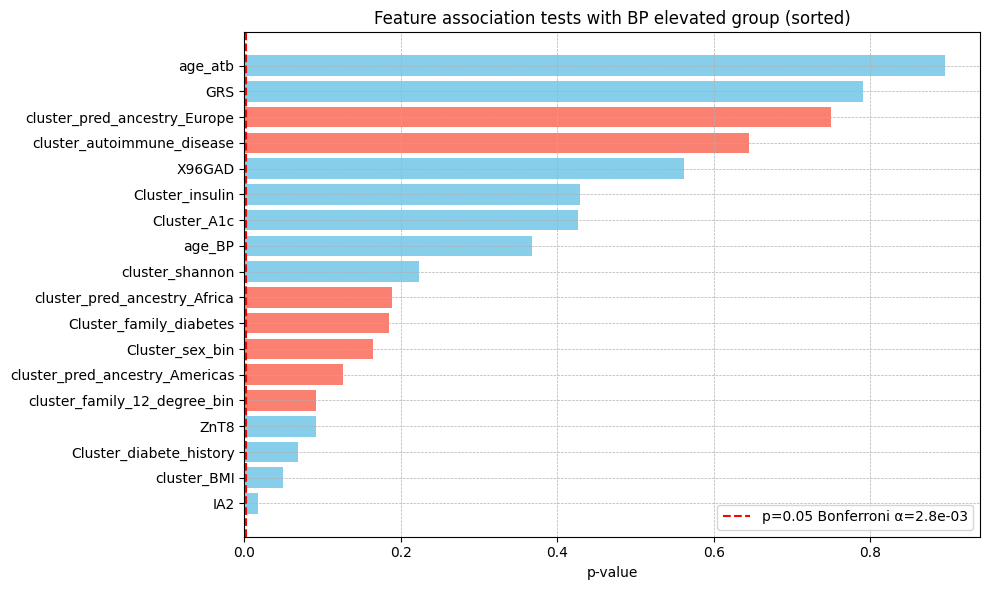

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f_oneway, chi2_contingency

# --- setup ---
# df is your full DataFrame, with 'Y' as the group label (0/1)
features = df.drop(columns=['Y'])
labels   = df['Y']

results = []

# --- loop over features ---
for col in features.columns:
    series = features[col]
    # drop NA for decision logic
    uniq = series.dropna().unique()

    # detect "binary": either boolean dtype, or exactly two unique values in {0,1,"Yes","No"}
    is_binary = (
        pd.api.types.is_bool_dtype(series)
        or (
            len(uniq)==2
            and set(uniq).issubset({0,1,"Yes","No","yes","no","TRUE","FALSE"})
        )
    )

    if is_binary:
        # chi‐square on contingency table
        ct    = pd.crosstab(labels, series)
        chi2, p, dof, ex = chi2_contingency(ct)
        test = 'chi2'
    else:
        # one‐way ANOVA
        groups = [series[labels==g].dropna() for g in labels.unique()]
        # require at least 2 groups with data
        if len([g for g in groups if len(g)>0]) < 2:
            p = np.nan
        else:
            _, p = f_oneway(*groups)
        test = 'anova'

    results.append((col, p, test))

# --- assemble results ---
res_df = pd.DataFrame(results, columns=['Feature','p-value','Test'])
bonf_thresh = 0.05 / len(features.columns)
#res_df['Significant'] = np.where(res_df['p-value'] < bonf_thresh, 'Yes', 'No')

# --- optional: sort and display ---
print(res_df.sort_values('p-value'))


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f_oneway, chi2_contingency

# --- assume df is already loaded, and you've run the tests into res_df ---
# res_df has columns ['Feature','p-value','Test']

# sort by p‑value ascending
res_df = res_df.sort_values('p-value', ascending=True).reset_index(drop=True)

# Bonferroni threshold
bonf_thresh = 0.05 / res_df.shape[0]

# plotting
plt.figure(figsize=(10, 6))
colors = res_df['Test'].map({'anova':'skyblue', 'chi2':'salmon'})

# horizontal bar, index order matches sorted res_df
plt.barh(res_df['Feature'], res_df['p-value'], color=colors)

# set x‑axis to log scale
plt.xlabel('p-value')
plt.title('Feature association tests with BP elevated group (sorted)')
plt.axvline(bonf_thresh, color='red', linestyle='--',
            label=f'p=0.05 Bonferroni α={bonf_thresh:.1e}')
plt.legend()
plt.grid(True, which="both", ls="--", lw=0.5)
plt.tight_layout()
plt.show()



## Modeling Srategy

We applied and evaluated the following classifiers on a held-out test set using two evaluataion metrics: **ROC** curve and **Precision-Recall** curve.. The ROC AUC measures the model's ability to distinguish between the two classes, while the PR AUC focuses on the model's performance on the positive class (elevated BP).

We considered the follwing models: 

1. Logistic Regression (standardized)  

Standardized logistic regression fits a linear model linking predictor variables to the log‐odds of the binary outcome. This model serves as our baseline: it’s fast to train, yields easily interpretable odds‐ratios, and sets a performance floor against which more complex learners can be judged.


2. LASSO Logistic (`glmnet`)  


LASSO logistic regression introduces an L₁ penalty on the magnitude of coefficients, shrinking many to exactly zero. This regularization both guards against over‐fitting (especially when the number of predictors is large relative to sample size) and performs automatic feature selection by excluding weakly predictive variables. We fit via glmnet::cv.glmnet() using AUC‐optimized cross‐validation to select the penalty strength (λ). The resulting sparse model highlights only the strongest predictors, simplifying interpretation and often improving generalization.



3. Random Forest (caret)  

Random forests build an ensemble of decision trees, each grown on a bootstrap‐sample of the training set and considering a random subset of predictors at each split. By averaging across many decorrelated trees, the model captures non‑linear relationships and high‑order interactions while reducing variance. We used caret::train(method = "rf") with repeated cross‑validation to tune the number of variables tried at each split (mtry). Random forests are robust to outliers, handle mixed‐type features, and provide built‑in measures of variable importance.

4. XGBoost (mlr)  

XGBoost implements gradient boosting of decision trees, sequentially fitting each new tree to the residual errors of its predecessors. This method excels at capturing complex interactions and skewed distributions by optimizing a regularized objective (including L₁/L₂ penalties) under a fast, distributed framework. We wrapped it in mlr, tuning tree depth, learning rate, and sampling parameters via randomized search on PR‑AUC. XGBoost often outperforms other algorithms when appropriately tuned, at the cost of more hyperparameter complexity. However, it turns out our data is not large enough to benefit from the XGBoost algorithm and the perofmance is dominated by the age factor. Therefore, we do not recommend using XGBoost for this dataset.

5. Linear SVM (caret)  

A linear Support Vector Machine seeks the hyperplane that maximizes the margin between classes in feature space. It’s effectively a large‑margin classifier that’s robust to high‑dimensional data and can be less sensitive to outliers than logistic regression. We trained with caret::train(method = "svmLinear"), tuning the cost parameter (C) via cross‑validation to balance margin width against misclassification error. Although its decision boundary is linear, SVMs can yield strong performance in cases where classes are well‑separated in a high‐dimensional feature representation. However, due to limited samle size of this project, the performance of SVM is not as good as the Random Forest model on our dataset. 



## Conclusion

1. **Model Performance:**  
   - **Random Forest** achieved the highest discrimination (ROC AUC ≈ 0.71) among all methods (Figure 1), markedly outperforming all other models. The SVM and xgboost models performed similarly to the LASSO model and therefore not included in the figure below.
   - Note that the curve is not smooth due to the small sample size. We used 25% data as test-set. 

![Figure 1: Model performance ROC curves.](roc_all.jpeg)



2. **Key Take-away:**  
   - the dominate features are: BMI, a1C, GRS, IA2, and X96GAD.
   - This demonstrate that even though univariate analysis did not yield significant association results, the machine learning model is able to capture some complex interactions between features to predict the elevated BP group. 
   - However, the prediction performance is limited by the small sample size, imbalanced data, and signals in the feture pool.


   ![Figure 2: Feature importance in the random forest model.](5_3_rf_varimp_top10.jpeg)



4. **Next Steps:**  
   - **normotensive subjects:** there are very few normotensive subjects in the cohort (50 normotensive subjects versus 197). We need to add more normotensive subjects to the cohort to improve the model performance.   
   - **Genetic Features:** The GRS score is not performing as it is expected. We need to investigate the orignal genotypes (e.g. SNP dosage data) to see is any SNPs can be added as predictors.
   - **Other Features:** The model need to be updated with new data Imputed basal C-peptide (nmol/l), -Insulin pump therapy (yes/no) and duration (months),...etc, which have not been incorporated yet.
   - **Validation:** The current model performance is evaluated only on one randomly selected training/test split. We need to investigate if this is a robust model by using cross-validation and/or bootstrapping.
